<h1><center>Rain In Australia: Feature Engineering </center></h1> <a class="anchor" id="australia-map"></a>

In [41]:
australia_map()

Hello! The intent of this notebook is to share my findings and ideas in regards to "Rain In Australia" 2007-2015 dataset. I am an aspiring data scientist and the goal of this mini-project is to enhance my feature engineering skills. I understand that there is probably a lot more one can do with this dataset, so I would love to hear what you think! :)
</br> I also created a simple Plotly Dash app with visualizations, which you can find on my github right here:
</br> https://github.com/vvvvvaves/Kaggle-Datasets/tree/main/Rain%20In%20Australia

__Note:__ if you wish to run this notebook yourself, activate all of the cells under "Necessary Imports" section. They take up quite a lot of space, so I placed them at the end of this notebook.

## Table of Contents
* [EDA and Feature Engineering](#eda_and_fe)
    * [load_and_split()](#load_and_split)
    * [Data imputation/Missing values](#imputation)
    * [Target-encode EVERYTHING with respect to location](#target_encoding)
        * [Wind directions](#wind_directions)
            * [Portland](#wind_directions_portland)
            * [Sydney](#wind_directions_sydney)
            * [Melbourne](#wind_directions_melbourne)
            * [Cairns](#wind_directions_cairns)
        * [Months](#months)
        * [RainToday_*location*](#raintoday_location)
    * [Rolling features and correlations](#rolling_features)
    * [Numerical Features](#numerical_features)
    * [Outliers](#outliers)
    * [Accumulated probabilities](#accumulated_probabilities)
* [Model training and evaluation](#train_and_eval)
    * [ROC AUC score](#roc_auc_score)
    * [Confusion matrices, metrics and thresholds](#report)
    * [SHAP values and feature importances](#shap)
* [One thing I did not understand](#question)
* [Conclusion](#conclusion)
</br></br>
* [Necessary Imports](#imports)
    * [Visualizations](#visualizations)
    * [OutlierDetection](#outlierdetection)
    * [Preprocessor](#preprocessor)

<h1><center>EDA and Feature Engineering</center></h1> <a class="anchor" id="eda_and_fe"></a>

In this chapter I will go through each function in Preprocessor class and explain why I made the decision that I made. To follow along, you can look at the functions themselves, which are shown in [Necessary Imports/Preprocessor](#preprocessor) section.

### load_and_split()  <a class="anchor" id="load_and_split"></a>

The 109103 index may seem random but I promise there is a logic behind that.

The thing is, I sorted this whole dataset firstly by Date and then, by Location. I chose 25% of the data to be my train set. 145460 (which is the size of the whole set) multiplied by 0.75 equals 109095. It is sort of a rolling split with respect to time, which, I think, is appropriate for a time series problem. But I wanted to have an equal repsentation of each location, so I found an index closest to 109095 where locations circle back in alphabetical order, which turned out to be at index 109103, June 15th, 2015, Adelaide.

In [7]:
dataset = pd.read_csv('data/weatherAUS.csv')

dataset.sort_values(by=['Date', 'Location'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

dataset.iloc[int(dataset.shape[0] * 0.75):].head(10)

Date     Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
109095  2015-06-14        Uluru      9.3     24.8       0.0          NaN   
109096  2015-06-14   WaggaWagga      3.9     17.8       0.0          1.4   
109097  2015-06-14      Walpole     11.7     15.8       1.0          NaN   
109098  2015-06-14     Watsonia      3.4     17.0       0.0          2.6   
109099  2015-06-14  Williamtown      7.4     19.8       NaN          NaN   
109100  2015-06-14  Witchcliffe      4.2     15.6       0.8          NaN   
109101  2015-06-14   Wollongong     10.8     18.4       0.0          NaN   
109102  2015-06-14      Woomera     13.3     16.2       0.0          NaN   
109103  2015-06-15     Adelaide     13.2     15.5       1.2          2.8   
109104  2015-06-15       Albany     13.6     18.8       0.8          1.2   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
109095       NaN         ENE           33.0        ESE  ...        72.0   
109096       7.7           E           22.0        ESE  ...        85.0   
109097       NaN          SE           39.0         SE  ...        70.0   
109098       6.0         ENE           50.0         NE  ...       100.0   
109099       NaN          NW           20.0         NW  ...        89.0   
109100       NaN         ESE           37.0        NaN  ...        99.0   
109101       NaN         WSW           19.0        WNW  ...        70.0   
109102       NaN           E           33.0          E  ...        97.0   
109103       NaN           E           24.0        SSE  ...        84.0   
109104       5.9         NaN            NaN         SE  ...        78.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
109095         35.0       1019.3       1015.9       NaN       1.0     15.2   
109096         56.0       1028.7       1025.5       6.0       3.0      8.6   
109097         75.0       1024.5       1022.9       NaN       NaN     13.0   
109098         60.0       1028.4       1025.2       7.0       6.0      5.0   
109099         69.0       1028.4       1025.4       8.0       1.0     11.0   
109100         55.0       1025.4       1022.5       NaN       NaN      9.6   
109101         65.0       1028.2       1025.6       NaN       NaN     15.2   
109102         88.0       1021.8       1019.0       7.0       7.0     13.6   
109103         75.0       1021.5       1018.6       NaN       NaN     13.9   
109104         66.0       1023.1       1021.4       6.0       2.0     16.2   

        Temp3pm  RainToday  RainTomorrow  
109095     24.3         No            No  
109096     17.4         No            No  
109097     14.4         No           Yes  
109098     16.9         No            No  
109099     18.1        NaN           Yes  
109100     15.1         No            No  
109101     17.8         No           NaN  
109102     15.5         No            No  
109103     15.4        Yes           Yes  
109104     17.7         No           Yes  

[10 rows x 23 columns]

In [8]:
train_set, test_set = Preprocessor.load_and_split()

I realize that there may have been a difference in amounts of rain at different locations in that split (maybe, some weather stations appeared later than others) but that seems to be fine.

In [9]:
bar_train = train_set.loc[train_set['RainTomorrow'] == 'Yes', 'Location'].value_counts(normalize=True).sort_index()
bar_test = test_set.loc[test_set['RainTomorrow'] == 'Yes', 'Location'].value_counts(normalize=True).sort_index()
percent = round(np.abs(bar_train-bar_test).mean(axis=0)*100, 2)
f"The absolute difference in amounts of rain between train and test is {percent}%."

'The absolute difference in amounts of rain between train and test is 0.23%.'

## Data imputation // Missing values <a class="anchor" id="imputation"></a>

I imputed missing values with a median for numerical features and a mode for categorical ones. But I did it, while also considering months and locations. (Basically, median temperature in a desert during winter is not the same as on the coastline in June.) Later I imputed my test set with those same values. If there is not a single measurement for some particular month and location, those cells remain NaN, which is okay, 'cause lightGBM knows how to work with that.

## Target-encode EVERYTHING with respect to location <a class="anchor" id="target_encoding"></a>

The one thing I really enjoyed when working with this dataset is looking at maps. To do that, I used __geopy__ to get longitude and latitude of each location.

(Although there was a small difficulty with location names. That is, Australia has three Richmonds, for example, and two Portlands. Not to mention cities with those same names exist on other continents. I checked proper names on http://www.bom.gov.au/climate/dwo, from which this dataset was gathered.)

## Wind Directions <a class="anchor" id="wind_directions"></a>

I figured that _different winds bring rains to different locations_:

### Portland: <a class="anchor" id="wind_directions_portland"></a>

In [90]:
plt.rcParams["figure.figsize"] = (8,6)
wind_direction_vs_location(train_set, 'Portland', show_location=True, zoom=9)

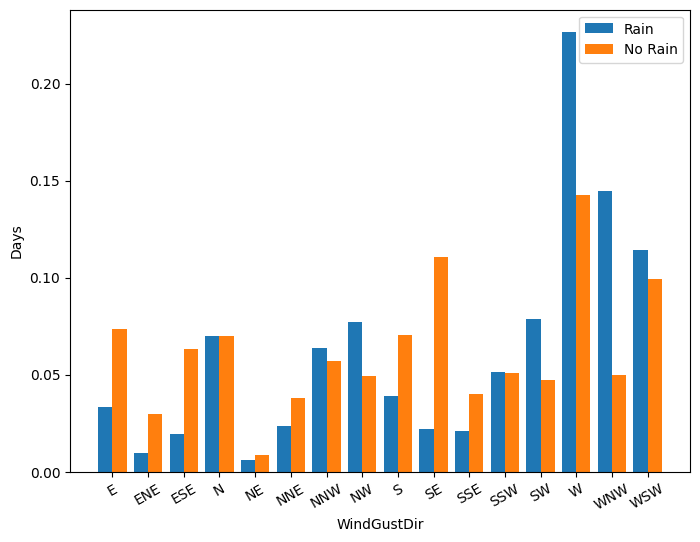

In [75]:
wind_direction_vs_location(train_set, 'Portland', show_location=False)

### Sydney: <a class="anchor" id="wind_directions_sydney"></a>

In [92]:
wind_direction_vs_location(train_set, 'Sydney', show_location=True, zoom=7)

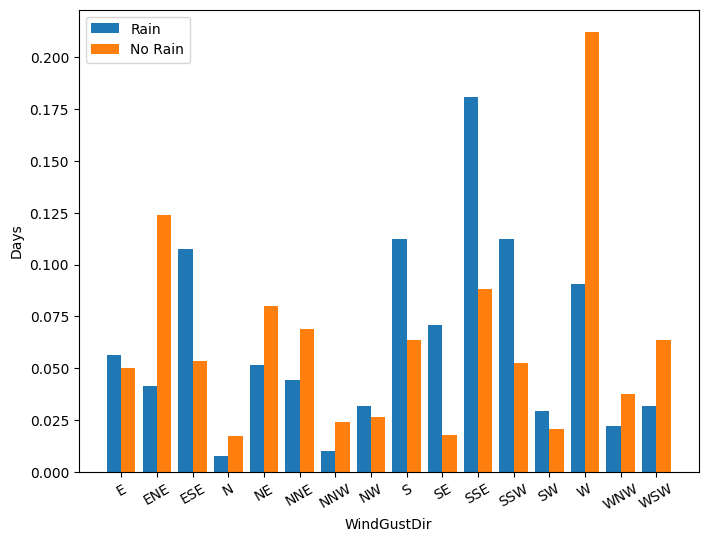

In [78]:
wind_direction_vs_location(train_set, 'Sydney', show_location=False)

And some locations are so hidden that only certain types of winds usually affect them:

### Melbourne: <a class="anchor" id="wind_directions_melbourne"></a>

In [94]:
wind_direction_vs_location(train_set, 'Melbourne', show_location=True, zoom=7)

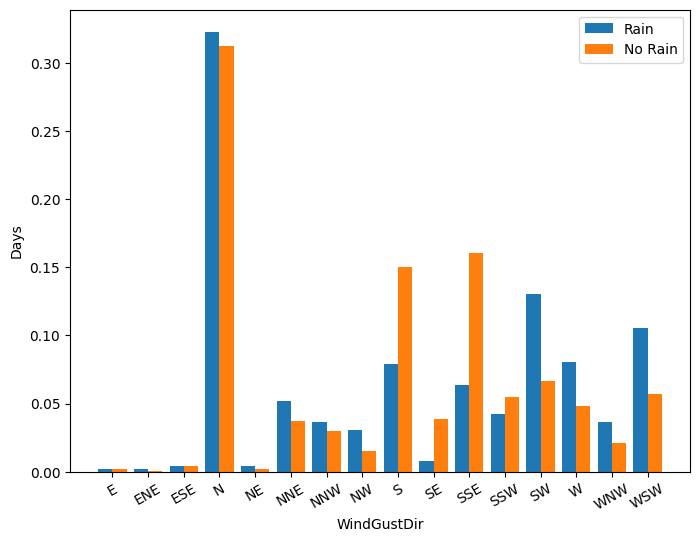

In [81]:
wind_direction_vs_location(train_set, 'Melbourne', show_location=False)

### Cairns: <a class="anchor" id="wind_directions_cairns"></a>

In [97]:
wind_direction_vs_location(train_set, 'Cairns', show_location=True, zoom=9)

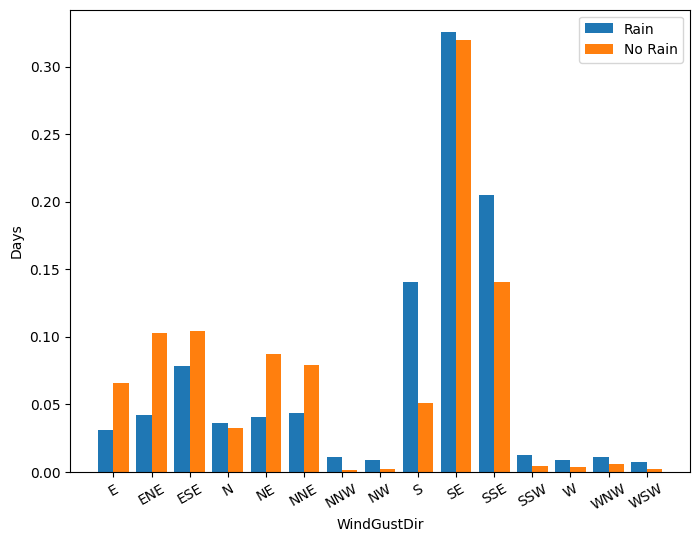

In [83]:
wind_direction_vs_location(train_set, 'Cairns', show_location=False)

It seemed like a good idea to target-encode all of the wind direction features with respect to locations.

Unfortunately, I cannot show every location here but you can check them out in my Plotly Dash app.

## Months: <a class="anchor" id="months"></a>

I also target-encoded months in that way, because, _as it turns out_, the frequency of rain is different depending on where and when.

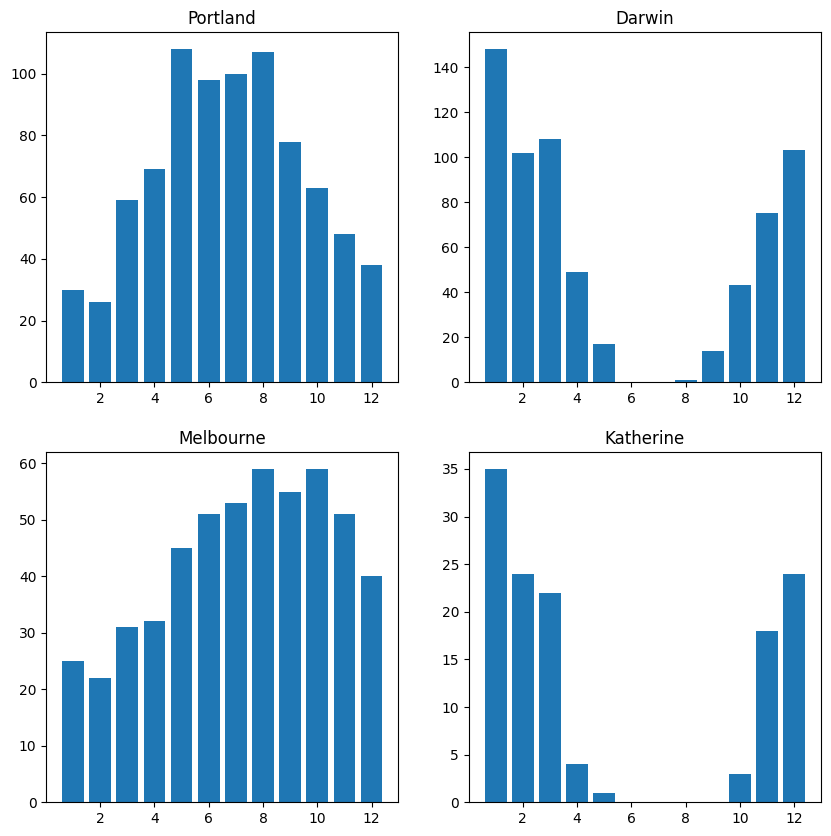

In [50]:
rain_vs_month_vs_location(['Portland', 'Darwin', 'Melbourne', 'Katherine'])

In [51]:
plt.rcParams["figure.figsize"] = (6,4)

Additionally, I target-encoded month and location features separately from each other, just in case. Although, the dependency between amounts of rain and months is only seen when zoomed in, when it comes to locations, it is clear that most of the rains in Australia fall on the coastline. You can notice it on the map [above](#australia-map), where locations such as Alice Springs and Uluru, hidden deep in Australian deserts, experience much less rain than those on the coast.

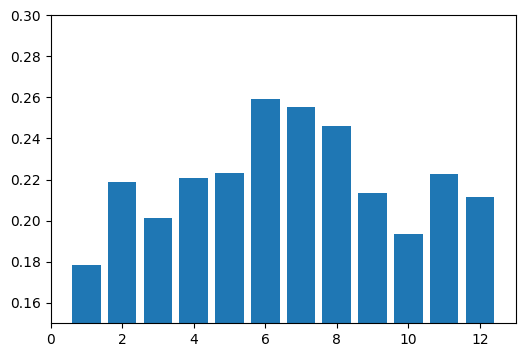

In [23]:
series_ = train_prep.loc[train_prep.RainTomorrow == 1, 'Month'].value_counts().sort_index() / train_prep.Month.value_counts().sort_index()
plt.bar(series_.index, series_.values)
ax = plt.axis([0, 13, 0.15, 0.3])

## RainToday_location <a class="anchor" id="raintoday_location"></a>

My idea for this set of features was that rain at one location can tell us something about a possibility of rain tomorrow at another location. I *also* target-encoded all of these features with respect to location. Let's look at the maps for some confirmation.

Notice:
1. The map is centered around a chosen location.
2. The size of the circle is the amount of rains in that location.
3. The color of each circle represents correlation between rainTomorrow at the chosen location and each location's RainToday.

In [52]:
raintoday_location('Sydney', zoom=5)

In [53]:
raintoday_location('Melbourne', zoom=4)

## Rolling Features and Correlations  <a class="anchor" id="rolling_features"></a>

I added mean and mode of many numerical and categorical features for the week before target date in hopes that it would give the model more accurate description of weather conditions than just one day's measurements. I have to admit that it wasn't very useful and basically the importance of that sort of feature heavily depended on the importance of the feature it was derived from.

I also added rolling features which described spearman correlation of numerical ones for the period of one week. The idea was that, if the rain was going to happen soon, the sunshine levels, for example, would gradually drop throughout the week giving us a negative correlation with respect to time, whereas humidity correlation would be closer to 1.

That is kind of true if you look at the distributions:

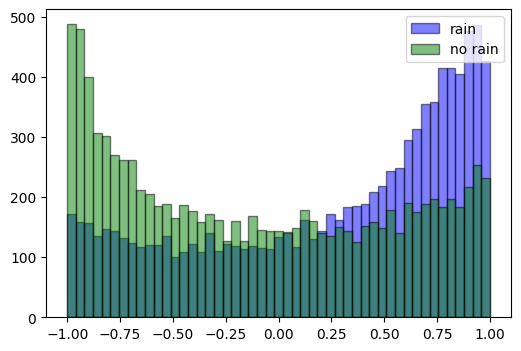

In [27]:
correlation_distributions('Humidity3pm_7days_corr')

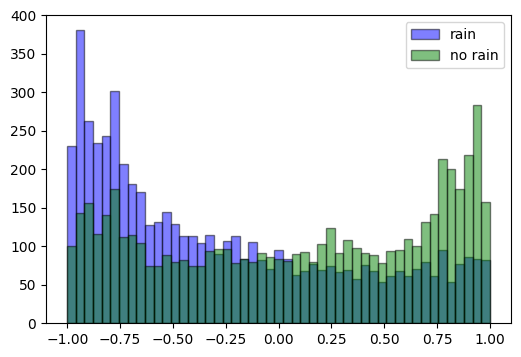

In [28]:
correlation_distributions('Sunshine_7days_corr')

Also, the probability of rain rises if it was raining for several days prior (which is kind of self-explanatory, but still).

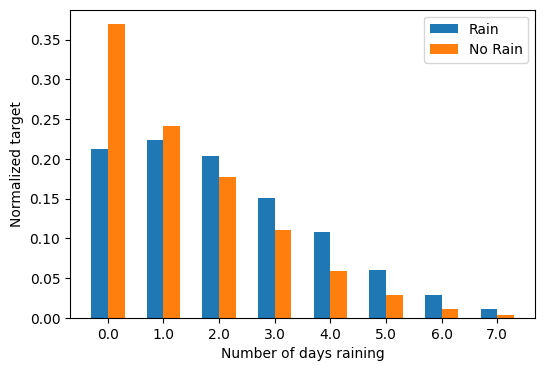

In [29]:
rain = train_prep.loc[train_prep.RainTomorrow == 1, 'RainToday_7days'].value_counts(normalize=True).sort_index()
no_rain = train_prep.loc[train_prep.RainTomorrow == 0, 'RainToday_7days'].value_counts(normalize=True).sort_index()
X = rain.index
X_axis = np.arange(len(X))
plt.bar(X_axis-0.15, rain.values, width=0.3, label='Rain')
plt.bar(X_axis+0.15, no_rain.values, width=0.3, label='No Rain')
plt.xticks(X_axis, X)
plt.xlabel('Number of days raining')
plt.ylabel('Normalized target')
plt.legend()

## Numerical Features  <a class="anchor" id="numerical_features"></a>

Numerical features such as Humidity, WindSpeed, Pressure and Sunshine had the main impact on the model. They are clearly far ahead in terms of importances which is shown on [shap-values](#shap) summary plot.

Look at how distinct are the differences in distributions on violin plots!

<AxesSubplot: xlabel='RainTomorrow', ylabel='Humidity3pm'>

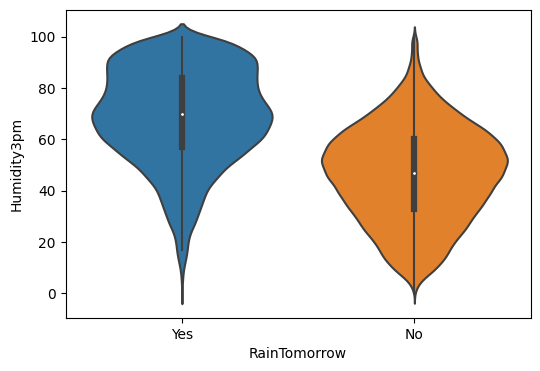

In [30]:
sns.violinplot(train_set, x='RainTomorrow', y='Humidity3pm')

<AxesSubplot: xlabel='RainTomorrow', ylabel='Sunshine'>

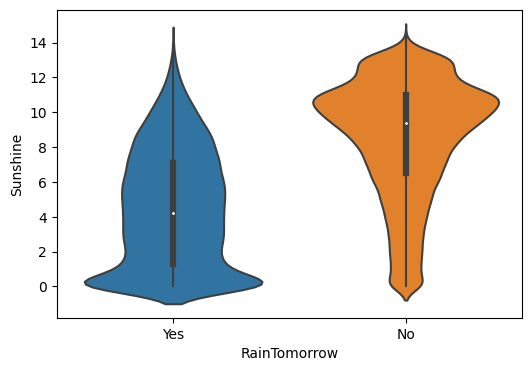

In [31]:
sns.violinplot(train_set, x='RainTomorrow', y='Sunshine')

<AxesSubplot: xlabel='RainTomorrow', ylabel='WindGustSpeed'>

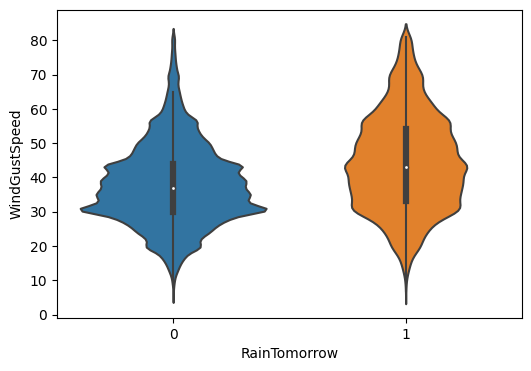

In [32]:
sns.violinplot(train_prep.loc[train_prep.is_outlier == 0], x='RainTomorrow', y='WindGustSpeed')

<AxesSubplot: xlabel='RainTomorrow', ylabel='Pressure3pm'>

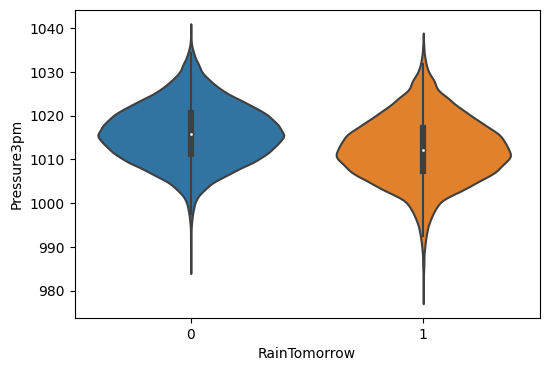

In [33]:
sns.violinplot(train_prep, x='RainTomorrow', y='Pressure3pm')

## Outliers  <a class="anchor" id="outliers"></a>

When I looked at the violin plot of Rainfall feature, I noticed these *huge* outliers:

<AxesSubplot: xlabel='RainTomorrow', ylabel='Rainfall'>

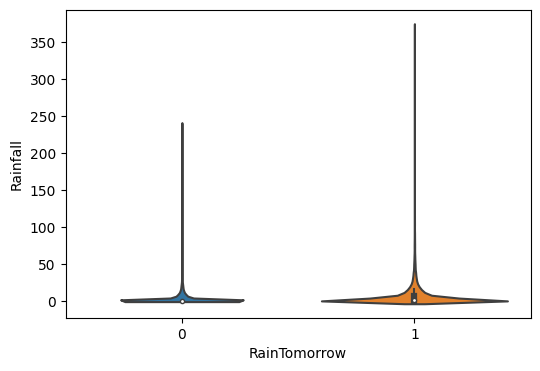

In [34]:
sns.violinplot(train_prep, x='RainTomorrow', y='Rainfall')

In [35]:
train_set.loc[train_set.Rainfall > 230]

Date      Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
2845    2009-01-12        Cairns     22.3     27.4     278.4          NaN   
3886    2009-02-03    Townsville     22.8     25.4     236.8          NaN   
16602   2009-11-07  CoffsHarbour     17.4     23.1     371.0          NaN   
37474   2011-02-04        Cairns     22.9     29.9     268.6          NaN   
38031   2011-02-16        Darwin     22.1     25.6     367.6          NaN   
102888  2015-02-08        Cairns     23.8     31.0     247.2          NaN   
106530  2015-04-23     Newcastle      NaN     21.7     240.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
2845         0.0          NW           59.0        SSE  ...        96.0   
3886         0.0         ESE           48.0        ESE  ...        98.0   
16602        3.5         NaN            NaN         SW  ...        93.0   
37474        2.0         ENE           37.0        ENE  ...        82.0   
38031        0.0         WSW           83.0        SSE  ...        98.0   
102888       2.0           E           44.0        SSE  ...       100.0   
106530       NaN         NaN            NaN         NW  ...        72.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
2845           98.0       1003.5        999.6       8.0       8.0     24.7   
3886           95.0       1003.8       1000.6       8.0       8.0     23.8   
16602          81.0       1026.6       1025.9       8.0       5.0     18.6   
37474          84.0       1011.1       1009.3       6.0       8.0     29.8   
38031          98.0        996.3        996.0       8.0       8.0     24.3   
102888         74.0       1014.2       1011.4       8.0       8.0     25.3   
106530         62.0          NaN          NaN       6.0       6.0     17.5   

        Temp3pm  RainToday  RainTomorrow  
2845       25.3        Yes           Yes  
3886       25.0        Yes           Yes  
16602      22.0        Yes           Yes  
37474      28.0        Yes           Yes  
38031      23.5        Yes           Yes  
102888     30.0        Yes           Yes  
106530     21.0        Yes            No  

[7 rows x 23 columns]

They correspond to some extremely heavy rains and cyclones in Australia (which are horrifying but kind of mesmerizing at the same time.)

For example, here is a video of February 16th, 2011, Darwin - cyclone Carlos. https://www.youtube.com/watch?v=2uYMyot6WrY

And here is a satellite picture of cyclone Yasi (taken from [Wikipedia](https://en.wikipedia.org/wiki/Cyclone_Yasi)), which went through Cairns on February 4th, 2011.
</br> 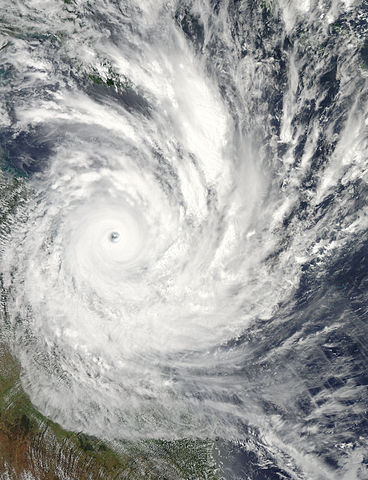

Ten thousands of people were forced to move from their homes (wikipedia) because of that one.

Anyway, I decided to leave those outliers and detect them by their Z-score.

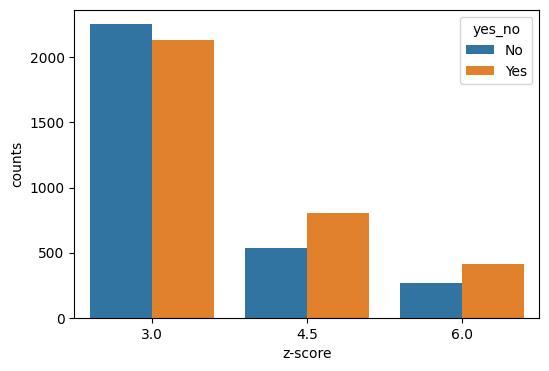

In [37]:
l_ = show_outliers([3, 4.5, 6])

Whereas in the whole dataset probability of rain is 22.4%, for those outliers it is nearly 50% and higher.

## Accumulated probabilities <a class="anchor" id="accumulated_probabilities"></a>

I summed up all of the *target-encoded with respect to location* features, which basically gave me not a bad result! Generally, the number is higher for cases with positive target value. The impact of this feature shows on [shap-values](#shap) summary plot as well.

<AxesSubplot: xlabel='RainTomorrow', ylabel='Accumulated_probabilities'>

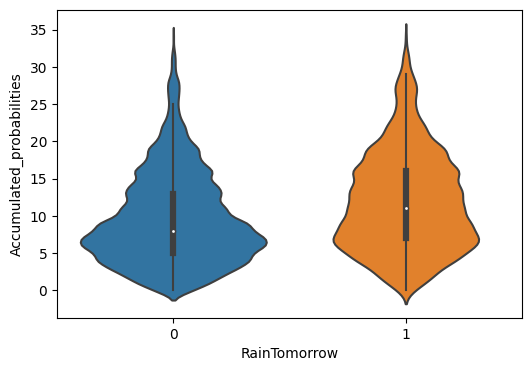

In [38]:
sns.violinplot(train_prep.loc[train_prep.Accumulated_probabilities < 35], y='Accumulated_probabilities', x='RainTomorrow')

<h1><center>Model training and evaluation</center></h1> <a class="anchor" id="train_and_eval"></a>

In [18]:
train_prep = preprocessor.preprocess(train_set, visualize=False, train=True)
train_X, train_y = train_prep.drop('RainTomorrow', axis=1), train_prep.RainTomorrow
fixed_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
lgb_params = {

    "objective": "binary",
    "learning_rate": 0.01,
    "num_threads": 10,
    "metric": "AUC",
    "seed": 42,
    "verbose":-1,
    "class_weight": "balanced",
    
     #regularization
    "colsample_bytree": 0.7,
    "subsample": 0.8,

    "subsample_freq": 1,
    "min_data_in_leaf": 150,

    "num_leaves":17,
    
    "n_estimators":3500
}

lgb_train = lgb.Dataset(train_X, label=train_y.fillna(0), free_raw_data=False)
result = lgb.cv(lgb_params, lgb_train, folds=fixed_skf, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(500)], eval_train_metric=True, return_cvbooster=False)

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\lightgbm\engine.py:573: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] Unknown parameter: class_weight
Training until validation scores don't improve for 10 rounds
[500]	cv_agg's train auc: 0.897978 + 0.000400514	cv_agg's valid auc: 0.89022 + 0.00184387
[1000]	cv_agg's train auc: 0.9095 + 0.00043674	cv_agg's valid auc: 0.896878 + 0.00186901
[1500]	cv_agg's train auc: 0.91735 + 0.000399426	cv_agg's valid auc: 0.899723 + 0.00194649
[2000]	cv_agg's train auc: 0.923875 + 0.00035609	cv_agg's valid auc: 0.901559 + 0.00200766
[2500]	cv_agg's train auc: 0.929651 + 0.000328615	cv_agg's valid auc: 0.90289 + 0.00202708
[3000]	cv_agg's train auc: 0.934857 + 0.000348673	cv_agg's valid auc: 0.903926 + 0.0019987
[3500]	cv_agg's train auc: 0.939669 + 0.000320208	cv_agg's valid auc: 0.904748 + 0.00196638
Did not meet early stopping. Best iteration is:
[3500]	cv_agg's train auc: 0.939669 + 0.000320208	cv_agg's valid auc: 0.904748 + 0.00196638


In [41]:
lgb_clf = lgb.LGBMClassifier(**lgb_params)
lgb_clf.fit(train_X, train_y.fillna(0))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
               learning_rate=0.01, metric='AUC', min_data_in_leaf=150,
               n_estimators=3500, num_leaves=17, num_threads=10,
               objective='binary', seed=42, subsample=0.8, subsample_freq=1,
               verbose=-1)

In [64]:
test_prep = preprocessor.preprocess(test_set, visualize=False, train=False)
test_X, test_y = test_prep.drop('RainTomorrow', axis=1), test_prep.RainTomorrow.fillna(0)

## ROC AUC Score  <a class="anchor" id="roc_auc_score"></a>

In [58]:
pd.DataFrame(result)[['train auc-mean', 'valid auc-mean']].iloc[-1]

train auc-mean    0.939669
valid auc-mean    0.904748
Name: 3499, dtype: float64

In [65]:
probs = lgb_clf.predict_proba(test_X)[:,1]
score = roc_auc_score(test_y, probs)
f"ROC AUC Score on test set is {round(score, 5)}"

'ROC AUC Score on test set is 0.88231'

## Confusion matrices, metrics and thresholds <a class="anchor" id="report"></a>

### Threshold: 0.4

In [80]:
metrics(0.4)

Confusion matrix:
[[21738  6720]
 [ 1370  6529]]

Normalized:
[[0.598 0.185]
 [0.038 0.18 ]]

Accuracy: 0.7775

Precision: 0.4928

Recall: 0.8266

F1-score: 0.6175


### Threshold: 0.5

In [81]:
metrics(0.5)

Confusion matrix:
[[23620  4838]
 [ 1890  6009]]

Normalized:
[[0.65  0.133]
 [0.052 0.165]]

Accuracy: 0.8149

Precision: 0.554

Recall: 0.7607

F1-score: 0.6411


### Threshold: 0.6

In [83]:
metrics(0.6)

Confusion matrix:
[[25107  3351]
 [ 2450  5449]]

Normalized:
[[0.691 0.092]
 [0.067 0.15 ]]

Accuracy: 0.8404

Precision: 0.6192

Recall: 0.6898

F1-score: 0.6526


### Threshold: 0.8

In [84]:
metrics(0.8)

Confusion matrix:
[[27344  1114]
 [ 4095  3804]]

Normalized:
[[0.752 0.031]
 [0.113 0.105]]

Accuracy: 0.8567

Precision: 0.7735

Recall: 0.4816

F1-score: 0.5936


## SHAP values and feature importances <a class="anchor" id="shap"></a>

In [87]:
with open('final_shap_values.pickle', 'rb') as handle:
    shap_values = pickle.load(handle)

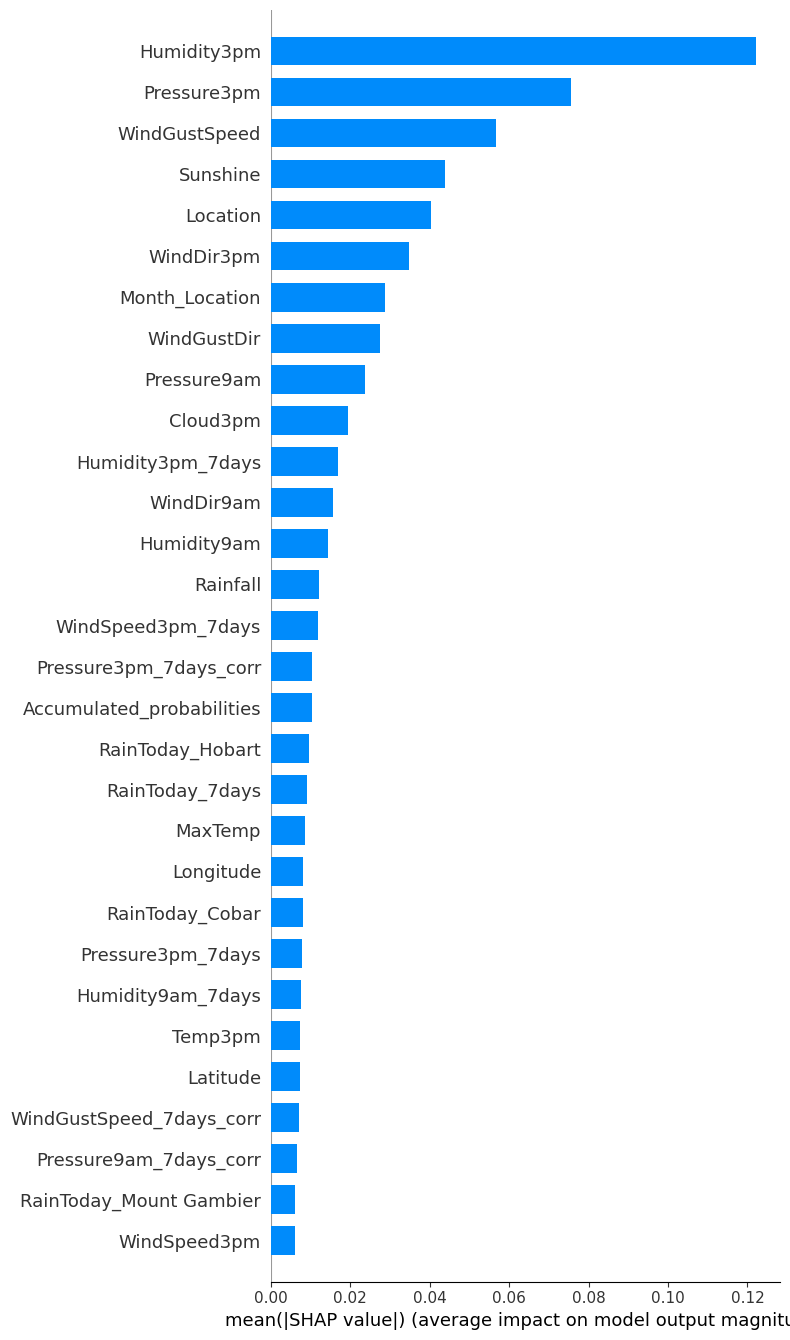

In [90]:
shap.summary_plot(shap_values, train_X, plot_type='bar', max_display=30)

As we can notice, plain numerical features such as **Humidity3pm**, **Pressure3pm**, **WindGustSpeed** and **Sunshine** had the most noticeable impact on the model. Right after them come target-encoded categorical attributes: **Location**, **WindDir3pm**, **Month_Location**, **WindGustDir** (all of them, except for the first one, are encoded with respect to location). Rolling features weren't much useful, their importance is correlated with the importance of the feature they were derived from.

The thing that seems interesting to me is that out of all **RainToday_location** features the most important one turned out to be **RainToday_Hobart**.

In [54]:
raintoday_location('Hobart', center='Melbourne', zoom=4)

It can be connected to the fact that this part of Australia has high density of locations. Most of the rains from the dataset happen in that South-East corner of the continent. Moreover, it seems like north winds would bring rain firstly to Tasmania and then move further in the direction of Victoria and South Australia. If it is raining in Hobart _today_, we can assume this rain will come to Melbourne by tomorrow.

<h1><center>One thing I did not understand</center></h1> <a class="anchor" id="question"></a>

Those are not all of the features I came up with when working on this dataset. In order to give a model more information about the surroundings, I added rolling correlation features of every location, much like I did with **RainToday_location**.

Final dataset looked like this:

In [13]:
__train_prep = preprocessor.preprocess(train_set, visualize=False, train=True, include_thing=True)

In [14]:
__train_prep.tail(3)

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
109100  0.156699     18.9     33.2       0.0          4.0       NaN   
109101  0.151914      5.5     16.6       0.0          NaN       NaN   
109102  0.063397      9.3     24.8       0.0          NaN       NaN   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  \
109100     0.118562           28.0    0.157725    0.071437  ...   
109101     0.247378           20.0    0.123986    0.248388  ...   
109102     0.040008           33.0    0.045685    0.054837  ...   

        Uluru_Humidity3pm_7days_corr  Uluru_Pressure9am_7days_corr  \
109100                     -0.730297                     -0.994538   
109101                     -0.730297                     -0.994538   
109102                     -0.730297                     -0.994538   

        Uluru_Pressure3pm_7days_corr  Uluru_Cloud9am_7days_corr  \
109100                     -0.974574                        NaN   
109101                     -0.974574                        NaN   
109102                     -0.974574                        NaN   

        Uluru_Cloud3pm_7days_corr  Uluru_Temp9am_7days_corr  \
109100                   0.258199                  0.791842   
109101                   0.258199                  0.791842   
109102                   0.258199                  0.791842   

        Uluru_Temp3pm_7days_corr  Uluru_RainToday_7days_corr  Month_Location  \
109100                  0.970319                    0.112903        0.000705   
109101                  0.970319                    0.139296        0.189022   
109102                  0.970319                    0.038123        0.067549   

        Accumulated_probabilities  
109100                   8.058897  
109101                   7.406067  
109102                   3.419511  

[3 rows x 945 columns]

Correlation features:

In [15]:
__train_prep[__train_prep.columns[150:200]].tail(3)

Adelaide_WindSpeed9am_7days_corr  Adelaide_WindSpeed3pm_7days_corr  \
109100                         -0.467099                         -0.774597   
109101                         -0.467099                         -0.774597   
109102                         -0.467099                         -0.774597   

        Adelaide_Humidity9am_7days_corr  Adelaide_Humidity3pm_7days_corr  \
109100                        -0.083045                         0.737442   
109101                        -0.083045                         0.737442   
109102                        -0.083045                         0.737442   

        Adelaide_Pressure9am_7days_corr  Adelaide_Pressure3pm_7days_corr  \
109100                        -0.987522                        -0.961234   
109101                        -0.987522                        -0.961234   
109102                        -0.987522                        -0.961234   

        Adelaide_Cloud9am_7days_corr  Adelaide_Cloud3pm_7days_corr  \
109100                           NaN                           NaN   
109101                           NaN                           NaN   
109102                           NaN                           NaN   

        Adelaide_Temp9am_7days_corr  Adelaide_Temp3pm_7days_corr  ...  \
109100                     0.778655                     0.452649  ...   
109101                     0.778655                     0.452649  ...   
109102                     0.778655                     0.452649  ...   

        Darwin_Cloud9am_7days_corr  Darwin_Cloud3pm_7days_corr  \
109100                   -0.316228                         0.0   
109101                   -0.316228                         0.0   
109102                   -0.316228                         0.0   

        Darwin_Temp9am_7days_corr  Darwin_Temp3pm_7days_corr  \
109100                  -0.423418                  -0.366962   
109101                  -0.423418                  -0.366962   
109102                  -0.423418                  -0.366962   

        Darwin_RainToday_7days_corr  Hobart_MinTemp_7days_corr  \
109100                     0.096579                  -0.387056   
109101                     0.193159                  -0.387056   
109102                     0.052314                  -0.387056   

        Hobart_MaxTemp_7days_corr  Hobart_Rainfall_7days_corr  \
109100                  -0.938672                         NaN   
109101                  -0.938672                         NaN   
109102                  -0.938672                         NaN   

        Hobart_Evaporation_7days_corr  Hobart_Sunshine_7days_corr  
109100                      -0.282267                   -0.757423  
109101                      -0.282267                   -0.757423  
109102                      -0.282267                   -0.757423  

[3 rows x 50 columns]

Cross-validation on this dataset showed that my score had improved from 0.9 to 0.915-0.92.

In [16]:
train_X, train_y = __train_prep.drop('RainTomorrow', axis=1), __train_prep.RainTomorrow.fillna(0)

In [20]:
lgb_params = {

    "objective": "binary",
    "learning_rate": 0.05,
    "num_threads": 10,
    "metric": "AUC",
    "seed": 42,
   "verbose":-1,
    "class_weight": "balanced",
    
     #regularization
    "colsample_bytree": 0.7,
    "subsample": 0.8,

    "subsample_freq": 1,
    "min_data_in_leaf": 400,

    "num_leaves":7,
    
    "n_estimators":1700
    
    #categorical features
#     'cat_smooth': 5,
#     'min_data_per_group': 2
#     did not improve the results
    
}
lgb_train = lgb.Dataset(train_X, label=train_y.fillna(0), free_raw_data=False)
result = lgb.cv(lgb_params, lgb_train, 10_000, folds=fixed_skf, callbacks=[lgb.early_stopping(15), lgb.log_evaluation(500)], eval_train_metric=True)

Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 15 rounds
[500]	cv_agg's train auc: 0.916195 + 0.000298517	cv_agg's valid auc: 0.902812 + 0.00114878
[1000]	cv_agg's train auc: 0.932897 + 0.000135909	cv_agg's valid auc: 0.909936 + 0.000917608
[1500]	cv_agg's train auc: 0.944894 + 0.000122672	cv_agg's valid auc: 0.914146 + 0.00072216
Did not meet early stopping. Best iteration is:
[1700]	cv_agg's train auc: 0.948822 + 0.000101353	cv_agg's valid auc: 0.91542 + 0.000708955


But test score turned out to be much lower:

In [28]:
lgb_clf = lgb.LGBMClassifier(**lgb_params)
lgb_clf.fit(train_X, train_y)

In [25]:
test_prep = preprocessor.preprocess(test_set, visualize=False, train=False, include_thing=True)
test_X, test_y = test_prep.drop('RainTomorrow', axis=1), test_prep.RainTomorrow.fillna(0)

### ROC AUC score on train/validation:

In [23]:
pd.DataFrame(result)[['train auc-mean', 'valid auc-mean']].iloc[-1]

train auc-mean    0.948822
valid auc-mean    0.915420
Name: 1699, dtype: float64

### ROC AUC score on test set:

In [27]:
probs = lgb_clf.predict_proba(test_X)[:,1]
score = roc_auc_score(test_y, probs)
round(score, 5)

0.8747

I have an assumption that those kind of mismatches between validation and test scores happen when validation approach differs from test one. I now realize that, maybe, using 5-fold cross-validation for time-series problem was wrong and I should have taken last 10-20% of train set as my validation set. 

But is this really the case? After all, each row is independent and the model doesn't have any assumption about time dependency between cases. Anyway, I would love to read what you think about this!

<h1><center>Conclusions</center></h1> <a class="anchor" id="conclusion"></a>

1. Numerical features had the most impact on the model and did not need any preprocessing
2. Target-encoding with respect to location turned out to be quite useful
3. Using cross-validation on time-series problem was probably wrong
4. It seems as though it would be a good idea to train a separate model for each location.. but it's too time-consuming

I am going to return to this dataset later to, at least, try out a different validation approach. As for now, I hope you've found some of this interesting and have something to say in the comments. Thank you for reading :)

## Necessary Imports <a class="anchor" id="imports"></a>

In [30]:
import shap
import pickle
import folium, re
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from sklearn.model_selection import StratifiedKFold
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score

### Visualizations <a class="anchor" id="visualizations"></a>

In [31]:
def australia_map():
    total_rains = train_prep.groupby('Location')['RainTomorrow'].sum()
    total_rains.index.name = 'index'
    locations = preprocessor.locations.copy(deep=True)
    locations = locations.merge(total_rains.rename('Total_rains').astype(int).reset_index(),
                                left_on='Location_reduced',
                                right_on='index').drop('index', axis=1)
    fig = px.scatter_mapbox(locations,
                            lon=locations['Longitude'],
                            lat=locations['Latitude'],
                            zoom=3,
                            text=locations['Location_reduced'],
                            # color=,
                            size=locations['Total_rains'].values,
                            width=450 * 1.8 - 10,
                            height=300 * 1.8 + 50)
    Australia_latitude, Australia_longitude = -24.7761086, 134.755
    fig.update_layout(
        mapbox_style="white-bg",
        mapbox_layers=[
            {
                "below": 'traces',
                "sourcetype": "raster",
                "sourceattribution": "United States Geological Survey",
                "source": [
                    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
                ]
            }
        ])
    fig.update_layout(mapbox={'center': go.layout.mapbox.Center(lat=Australia_latitude, lon=Australia_longitude)})
    fig.update_layout(margin={"r": 20, "t": 20, "l": 20, "b": 20})
    return fig

In [74]:
def wind_direction_vs_location(data, location, show_location, zoom=9):
    if show_location:
        locations = preprocessor.locations.copy(deep=True)
        location_latitude = locations.loc[locations.Location_reduced == location, 'Latitude'].to_list()[0]
        location_longitude = locations.loc[locations.Location_reduced == location, 'Longitude'].to_list()[0]
        map_ = px.scatter_mapbox(pd.DataFrame({'lon': [location_longitude], 'lat': [location_latitude]}),
                                lon='lon',
                                 lat='lat',
                                 width=500,
                                  height=500,
                                zoom = zoom)

        map_.update_layout(mapbox_style="open-street-map",
                              mapbox={'center': go.layout.mapbox.Center(lat=location_latitude, lon=location_longitude)})
        map_.update_layout(margin={"r": 20, "t": 20, "l": 20, "b": 20})
        return map_
    else:
        rain = data.loc[(data.Location == location) & (data.RainTomorrow == 'Yes'), 'WindGustDir'].value_counts(normalize=True).sort_index()
        no_rain = data.loc[(data.Location == location) & (data.RainTomorrow == 'No'), 'WindGustDir'].value_counts(normalize=True).sort_index()

        X = rain.index
        X_axis = np.arange(len(X))
        plt.bar(X_axis-0.2, rain.values, width=0.4, label='Rain')
        plt.bar(X_axis+0.2, no_rain.values, width=0.4, label='No Rain')
        plt.xticks(X_axis, X)
        plt.xlabel("WindGustDir")
        plt.ylabel("Days")
        r = plt.xticks(rotation = 30)
        plt.legend()
        plt.show()

In [33]:
def raintoday_location(location, rain=1, zoom=7, center=None):
    # 1. Map is centered around chosen location.
    # 2. The size of the circle is the amount of rains in that location.
    # 3. The color of each circle represents correlation between rainTomorrow at the chosen location and each location's RainToday.
    locations = preprocessor.locations.copy(deep=True)

    selected_columns = [column for column in train_prep.columns if 'RainToday_' in column]
    total_rains = train_prep.groupby('Location')['RainTomorrow'].sum()
    total_rains.index.name = 'index'
    locations = locations.merge(total_rains.rename('Total_rains').astype(int).reset_index(),
                                left_on='Location_reduced',
                                right_on='index').drop('index', axis=1)
    relative_raintoday = train_prep.loc[
        (train_prep.RainTomorrow == 1) & (train_prep.Location == location), selected_columns].sum(axis=0)
    relative_raintoday.index = relative_raintoday.index.to_series().apply(lambda txt: txt[10:])
    locations = locations.merge(relative_raintoday.rename('relative_RainToday').astype(int).reset_index(),
                                left_on='Location_reduced', right_on='index').drop('index', axis=1)

    fig = px.scatter_mapbox(locations,
                            lon=locations['Longitude'],
                            lat=locations['Latitude'],
                            zoom=zoom,
                            color=locations['relative_RainToday'],
                            size=locations['Total_rains'].values,
                            width=450 * 1.5,
                            height=300 * 1.5 + 50)
    if center is None:
        location_latitude = locations.loc[locations.Location_reduced == location, 'Latitude'].to_list()[0]
        location_longitude = locations.loc[locations.Location_reduced == location, 'Longitude'].to_list()[0]
    else:
        location_latitude = locations.loc[locations.Location_reduced == center, 'Latitude'].to_list()[0]
        location_longitude = locations.loc[locations.Location_reduced == center, 'Longitude'].to_list()[0]
        
    fig.update_layout(mapbox_style="open-street-map",
                      mapbox={'center': go.layout.mapbox.Center(lat=location_latitude, lon=location_longitude)})
    fig.update_layout(margin={"r": 20, "t": 20, "l": 20, "b": 20})
    return fig

In [34]:
def show_outliers(thresholds):
    l_ = []
    for threshold in thresholds:
        detector = OutlierDetection(threshold=threshold)
        detector.fit(train_set)

        outliers = detector.transform(train_set)
        outlier_indeces = set()
        for k in outliers.keys():
            outlier_indeces.update(outliers[k])

        is_outlier = pd.Series(np.zeros(train_set.shape[0]))
        is_outlier.loc[list(outlier_indeces)] = 1
        series_ = train_set.loc[is_outlier == 1, 'RainTomorrow'].value_counts().reset_index()
        series_['Z-score'] = threshold
        series_.columns = ['yes_no', 'counts', 'z-score']
        l_ += [series_]
    sns.barplot(pd.concat(l_), x='z-score', y='counts', hue='yes_no')

In [35]:
def correlation_distributions(column):
    bins = np.linspace(-1, 1, 50)

    rain = train_prep.loc[train_prep.RainTomorrow == 1, column].sample(n=10_000)
    no_rain = train_prep.loc[train_prep.RainTomorrow == 0, column].sample(n=10_000)

    plt.hist(rain, bins, alpha=0.5, label='rain', color = "blue", ec="black")
    plt.hist(no_rain, bins, alpha=0.5, label='no rain', color = "green", ec="black")
    plt.legend(loc='upper right')
    plt.show()

In [36]:
def metrics(threshold):
    func = np.vectorize(lambda p: 1 if p > threshold else 0)
    precision = precision_score(test_y, func(probs))
    recall = recall_score(test_y, func(probs))
    conf_m = confusion_matrix(test_y, func(probs))
    conf_m_norm = confusion_matrix(test_y, func(probs), normalize='all')
    f1_ = f1_score(test_y, func(probs))
    accuracy = accuracy_score(test_y, func(probs))
    print('Confusion matrix:')
    print(conf_m)
    print()
    print('Normalized:')
    print(np.vectorize(lambda n: round(n, 3))(conf_m_norm))
    print()
    print(f'Accuracy: {round(accuracy, 4)}\n')
    print(f'Precision: {round(precision, 4)}\n')
    print(f'Recall: {round(recall, 4)}\n')
    print(f'F1-score: {round(f1_, 4)}')

### OutlierDetection Class  <a class="anchor" id="outlierdetection"></a>

In [37]:
class OutlierDetection:
    def __init__(self, threshold=3):
        self.threshold=threshold
        self.numerical=None
        self.info=None
    
    def fit(self, X):
        self.numerical = [column for column in X.columns if X.dtypes[column] == float]
        self.info = {}
        for col in self.numerical:
            series_ = X[col].dropna()
            mean = np.mean(series_)
            std = np.std(series_)
            self.info[col] = {'mean': mean, 'std': std}
        return self
            
        
    def transform(self, X):
        outliers = {}
        for col in self.numerical:
            series_ = X[col].dropna()
            outliers_ = series_.apply(lambda x: (x-self.info[col]['mean'])/self.info[col]['std'] > self.threshold)
            outliers[col] = series_[outliers_].index.values
        return outliers
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [38]:
def rain_vs_month_vs_location(location):
    figure, axis  = plt.subplots(2, 2)
    figure.set_figwidth(10)
    figure.set_figheight(10)

    loc1 = train_prep.loc[(train_prep.RainTomorrow == 1) & (train_prep.Location == location[0]), 'Month'].value_counts().sort_index()
    axis[0, 0].bar(loc1.index, loc1.values)
    axis[0, 0].set_title(location[0])
    
    loc2 = train_prep.loc[(train_prep.RainTomorrow == 1) & (train_prep.Location == location[1]), 'Month'].value_counts().sort_index()
    axis[0, 1].bar(loc2.index, loc2.values)
    axis[0, 1].set_title(location[1])
    
    loc3 = train_prep.loc[(train_prep.RainTomorrow == 1) & (train_prep.Location == location[2]), 'Month'].value_counts().sort_index()
    axis[1, 0].bar(loc3.index, loc3.values)
    axis[1, 0].set_title(location[2])
    
    loc4 = train_prep.loc[(train_prep.RainTomorrow == 1) & (train_prep.Location == location[3]), 'Month'].value_counts().sort_index()
    axis[1, 1].bar(loc4.index, loc4.values)
    axis[1, 1].set_title(location[3])


### Preprocessor Class <a class="anchor" id="preprocessor"></a>

In [39]:
class Preprocessor:
    def __init__(self, numerical_impute_strategy, categorical_impute_strategy, roll_cols, roll_strategies, roll_period):
        if len(roll_cols) != len(roll_strategies):
            raise ValueError('Value Error: len(roll_cols) != len(roll_strategies).')
        self.locations = None
        self.numerical_impute_strategy = numerical_impute_strategy
        self.categorical_impute_strategy = categorical_impute_strategy
        self.roll_cols = roll_cols
        self.roll_strategies = roll_strategies
        self.roll_period = roll_period
        self.detector = None
        self.num_impute_data = None
        self.cat_impute_data = None
        self.encoders = {}

    def preprocess(self, _data, visualize=False, train=True, include_thing=False):
        data = _data.copy(deep=True)
        
        if train:
            self.detector = OutlierDetection()
            self.detector.fit(data)
            
        outliers = self.detector.transform(data)
        outlier_indeces = set()
        for k in outliers.keys():
            outlier_indeces.update(outliers[k])
        
        data['is_outlier'] = 0
        data.loc[list(outlier_indeces), 'is_outlier'] = 1

        for column in ['RainToday', 'RainTomorrow']:
            data.loc[data[column] == 'Yes', column] = 1
            data.loc[data[column] == 'No', column] = 0

        data['Year'] = pd.DatetimeIndex(data['Date']).year
        data['Month'] = pd.DatetimeIndex(data['Date']).month

        data['Location'] = data['Location'].apply(lambda loc: ' '.join(re.findall('[A-Z][^A-Z]+|[A-Z]+', loc)))
        data.loc[data.Location == 'Portland', 'Location'] = 'Portland, Victoria'
        data.loc[data.Location == 'Dartmoor', 'Location'] = 'Dartmoor, Victoria'
        data.loc[data.Location == 'Perth', 'Location'] = 'Perth, Western Australia'
        data.loc[data.Location == 'Richmond', 'Location'] = 'Richmond, New South Wales'
        data['Location'] = data.Location + ', Australia'

        if train:
            geolocator = Nominatim(user_agent="rain-in-australia-app")
            locations = {'Location_reduced': [], 'Location': [], 'Address': [], 'Latitude': [], 'Longitude': []}
            for location in data.Location.unique().tolist():
                location_enc = geolocator.geocode(location, language='en')
                if location_enc is None:
                    raise ValueError(f'Location not found: {location}')
                locations['Location_reduced'] += [location.split(', ')[0]]
                locations['Location'] += [location]
                locations['Address'] += [location_enc.address]
                locations['Latitude'] += [location_enc.latitude]
                locations['Longitude'] += [location_enc.longitude]
            self.locations = pd.DataFrame(locations)
            
        data = data.merge(self.locations[['Location', 'Latitude', 'Longitude']], left_on='Location',
                          right_on='Location')

        data['Location'] = data['Location'].apply(lambda loc: loc.split(', ')[0])
        
        if not visualize:
            self.impute(data, train=train)
        
        data['RainToday'] = data['RainToday'].astype(float)

        data = self.RainToday_Locations(data)
        
        for i, col in enumerate(self.roll_cols):
            data[f'{col}_{self.roll_period}days'] = Preprocessor.rolling_features_for_all_locations(data[col],
                                                                                                    data.Location,
                                                                                                    period=self.roll_period,
                                                                                                    shift=1,
                                                                                                    strategy=
                                                                                                    self.roll_strategies[
                                                                                                        i],
                                                                                                    corr=False)
            data[f'{col}_{self.roll_period}days_corr'] = Preprocessor.rolling_features_for_all_locations(data[col],
                                                                                                    data.Location,
                                                                                                    period=4,
                                                                                                    shift=0,
                                                                                                    strategy=
                                                                                                    self.roll_strategies[
                                                                                                        i],
                                                                                                    corr=True)
        if include_thing:
            data = self.generate_correlations(data)

        if not visualize:
            data = self.target_encoding(data, train=train)

        acc_col = [column for column in data.columns if 'RainToday_' in column and 'days' not in column or column == 'Month_Location']
        data['Accumulated_probabilities'] = data.loc[:, acc_col].sum(axis=1)
        
        data.drop('Date', axis=1, inplace=True)
        return data
    
    def generate_correlations(self, _data):
        data = _data.copy(deep=True)
        corrs = [column for column in data.columns if '_corr' in column]
        grouped_ = data.groupby(['Date'])[['Location']+corrs].apply(lambda r: r.set_index('Location').T)
        grouped_.index.names = ['Date', 'Features']
        grouped_ = grouped_.unstack(level='Features')
        grouped_.columns = ['_'.join(tupl) for tupl in grouped_.columns.values]
        grouped_.reset_index(inplace=True)
        data = data.merge(grouped_, left_on='Date', right_on='Date')
        return data

    def impute(self, data, train):
        columns = data.columns[2:-2]
        dtypes = data.dtypes[2:-2]
        numerical = [column for idx, column in enumerate(columns) if dtypes[idx] == float]
        categorical = [column for idx, column in enumerate(columns) if dtypes[idx] == object]
        if self.numerical_impute_strategy == 'mean' and train:
                self.num_impute_data = data.groupby(['Month', 'Location'])[numerical].mean().reset_index()
        elif self.numerical_impute_strategy == 'median' and train:
                self.num_impute_data = data.groupby(['Month', 'Location'])[numerical].median().reset_index()
        elif train:
            raise ValueError('Wrong numerical impute strategy.')

        if self.categorical_impute_strategy == 'mode' and train:
                self.cat_impute_data = data.groupby(['Month', 'Location'])[categorical].apply(lambda x: x.mode()).reset_index()
                self.cat_impute_data = self.cat_impute_data.loc[self.cat_impute_data['level_2'] == 0]
                self.cat_impute_data.drop('level_2', axis=1, inplace=True)
        elif train:
            raise ValueError('Wrong categorical impute strategy.')
        
        for location in data.Location.unique():
            for month in data.Month.unique():
                locf, monthf = (data.Location == location), (data.Month == month)
                for ccol in categorical:
                    nanf = (data[ccol].isna())
                    ilocf, imonthf = (self.cat_impute_data['Month'] == month), (self.cat_impute_data['Location'] == location)
                    data.loc[locf & monthf & nanf, ccol] = self.cat_impute_data.loc[ilocf & imonthf, ccol].reset_index(drop=True)[0]
                    
                for ncol in numerical:
                    nanf = (data[ncol].isna())
                    ilocf, imonthf = (self.num_impute_data['Month'] == month), (self.num_impute_data['Location'] == location)
                    data.loc[locf & monthf & nanf, ncol] = self.num_impute_data.loc[ilocf & imonthf, ncol].reset_index(drop=True)[0]
        
        return data
        

    def RainToday_Locations(self, data):
        grouped = data.groupby('Date')[['Location', 'RainToday']].apply(lambda r: r.set_index('Location').T)
        grouped = grouped.reset_index().drop('level_1', axis=1)
        if ',' in grouped.columns[1]:
            grouped.columns = ['Date'] + ['RainToday_' + col[:col.index(',')] for col in grouped.columns[1:]]
        else:
            grouped.columns = ['Date'] + ['RainToday_' + col for col in grouped.columns[1:]]
        return data.merge(grouped, left_on='Date', right_on='Date')

    def target_encoding(self, _data, train):
        data = _data.copy(deep=True)
        data['Month_Location'] = data['Month']
        location_cols = [column for column in data.columns if 'RainToday_' in column] + ['WindGustDir', 'WindDir9am',
                                                                                         'WindDir3pm', 'Month_Location']
      
        for location in data.Location.unique():
            location_df = data.loc[data.Location == location]
            
            if train:
                self.encoders[location] = TargetEncoder(cols=location_cols, handle_missing=0)
                data.loc[data.Location == location] = self.encoders[location].fit_transform(location_df, location_df.RainTomorrow)
            else:
                data.loc[data.Location == location] = self.encoders[location].transform(location_df, location_df.RainTomorrow)
                
        if train:
            self.encoders['in_general'] = TargetEncoder(cols=['Location', 'Month'])
            encoded = self.encoders['in_general'].fit_transform(data, data.RainTomorrow)
        else:
            encoded = self.encoders['in_general'].transform(data, data.RainTomorrow)

        for c in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            encoded[c] = encoded[c].astype(float)
        return encoded

    @staticmethod
    def rolling_features_for_all_locations(series_, locations, period, shift, strategy, corr=False):

        def rolling_features_for_location(series_, period, shift, strategy, corr=False):
            if not corr:
                first_n = []
                for i in range(period):
                    if i == 0:
                        first_n += [series_[i]]
                    else:
                        if strategy == 'mean':
                            first_n += [series_[:i + 1 - shift].mean()]
                        elif strategy == 'median':
                            first_n += [series_[:i + 1 - shift].median()]
                        elif strategy == 'sum':
                            first_n += [series_[:i + 1 - shift].sum()]
                        else:
                            raise ValueError('Wrong strategy.')

                if strategy == 'mean':
                    new_series = series_.shift(shift).rolling(period).mean()
                elif strategy == 'median':
                    new_series = series_.shift(shift).rolling(period).median()
                elif strategy == 'sum':
                    new_series = series_.shift(shift).rolling(period).sum()
                else:
                    raise ValueError('Wrong strategy.')

                new_series[:period] = first_n

                return new_series
            else:
                return series_.shift(shift).rolling(period).corr(other=series_.index.to_series())

        all_locations = []
        for location in locations.unique():
            one_location, index = series_[locations == location].reset_index(drop=True, inplace=False), series_[
                locations == location].index.to_series()
            new_series_for_location = rolling_features_for_location(one_location, period, shift, strategy, corr=corr)
            new_series_for_location.index = index
            all_locations += [new_series_for_location]
        return pd.concat(all_locations, axis=0)

    @staticmethod
    def load_and_split():
        dataset = pd.read_csv('data/weatherAUS.csv')
        dataset.sort_values(['Date', 'Location'], inplace=True)
        dataset.reset_index(drop=True, inplace=True)
        train, test = dataset.iloc[:109103], dataset.iloc[109103:]
        return train, test

### Preprocessed data necessary for visualization:

In [40]:
standard_roll_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                      'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                      'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                      'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
standard_roll_strategies = ['mean'] * (len(standard_roll_cols) - 1) + ['sum']
standard_roll_period = 7

preprocessor = Preprocessor('median', 'mode', standard_roll_cols, standard_roll_strategies, standard_roll_period)
train_set, test_set = preprocessor.load_and_split()
train_prep = preprocessor.preprocess(train_set, visualize=True, train=True)